In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import Ridge
from sklearn.impute import SimpleImputer

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report, accuracy_score
import sklearn.model_selection as cv

In [4]:
movies = pd.read_csv("movies.csv")
ratings = pd.read_csv("ratings.csv")
users = pd.read_csv("users.csv")

In [ ]:
print(movies.shape)
print(movies.head())

(3883, 3)
   movie_id                               title                        genres
0         1                    Toy Story (1995)   Animation|Children's|Comedy
1         2                      Jumanji (1995)  Adventure|Children's|Fantasy
2         3             Grumpier Old Men (1995)                Comedy|Romance
3         4            Waiting to Exhale (1995)                  Comedy|Drama
4         5  Father of the Bride Part II (1995)                        Comedy


In [ ]:
print(ratings.shape)
print(ratings.head())

(1000209, 4)
   user_id  movie_id  rating  timestamp
0        1      1193       5  978300760
1        1       661       3  978302109
2        1       914       3  978301968
3        1      3408       4  978300275
4        1      2355       5  978824291


In [ ]:
print(users.shape)
print(users.head())

(6040, 7)
   user_id gender  age  occupation zipcode  age_desc              occ_desc
0        1      F    1          10   48067  Under 18          K-12 student
1        2      M   56          16   70072       56+         self-employed
2        3      M   25          15   55117     25-34             scientist
3        4      M   45           7   02460     45-49  executive/managerial
4        5      M   25          20   55455     25-34                writer


## Combine datasets

In [3]:
# Merge movies and ratings
merged = ratings.merge(movies, on="movie_id", how="left")

In [4]:
# Join all 3 files into one dataframe
dataset = pd.merge(pd.merge(movies, ratings),users)
# Display 20 movies with highest ratings
dataset[['title','genres','rating']].sort_values('rating', ascending=False).head(20)

,title,genres,rating
1000185,"Contender, The (2000)",Drama|Thriller,5
1000182,"Contender, The (2000)",Drama|Thriller,5
25,Toy Story (1995),Animation|Children's|Comedy,5
24,Toy Story (1995),Animation|Children's|Comedy,5
21,Toy Story (1995),Animation|Children's|Comedy,5
19,Toy Story (1995),Animation|Children's|Comedy,5
18,Toy Story (1995),Animation|Children's|Comedy,5
17,Toy Story (1995),Animation|Children's|Comedy,5
1000173,"Contender, The (2000)",Drama|Thriller,5
1000171,"Contender, The (2000)",Drama|Thriller,5


## EDA

In [ ]:
# Check for missing values
movies.isna().sum()
ratings.isna().sum()
users.isna().sum()


,0
user_id,0
gender,0
age,0
occupation,0
zipcode,0
age_desc,0
occ_desc,0


### 1. Distribution of ratings

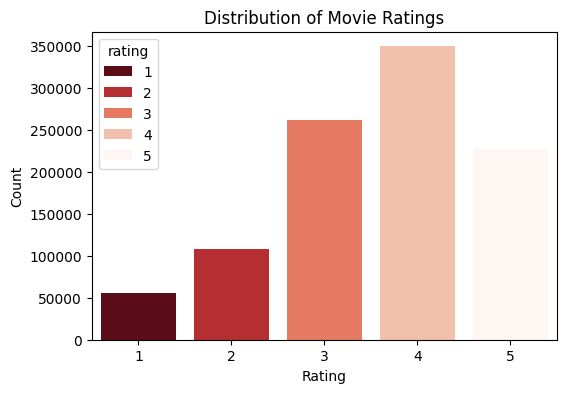

In [ ]:
plt.figure(figsize=(6,4))
sns.countplot(x="rating", data=ratings, palette="Reds_r", hue="rating")
plt.title("Distribution of Movie Ratings")
plt.xlabel("Rating")
plt.ylabel("Count")
plt.show()

### 2. Ratings per User

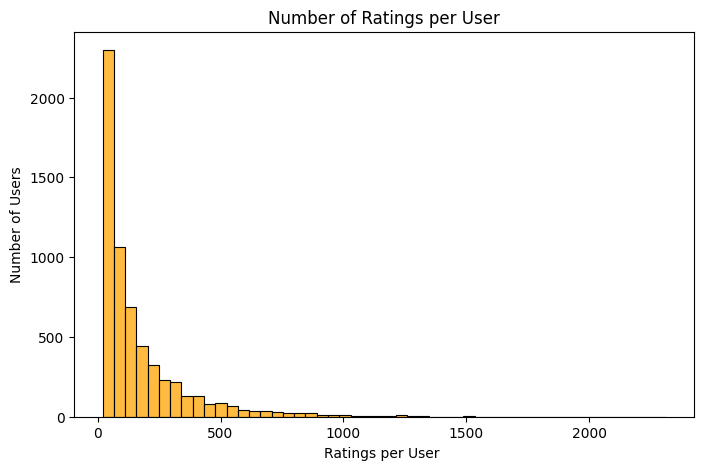

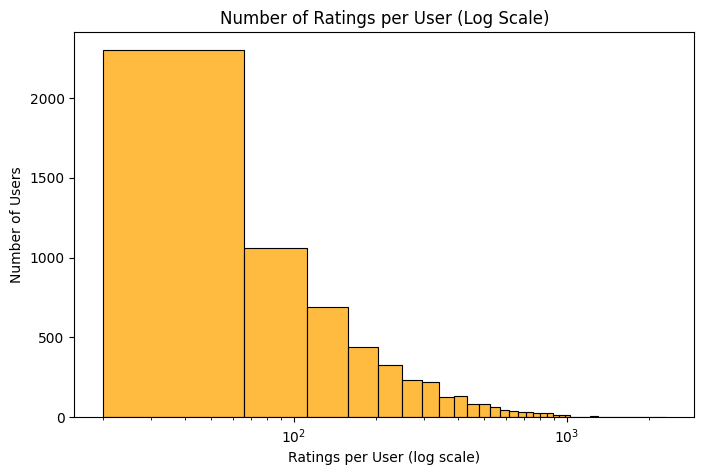

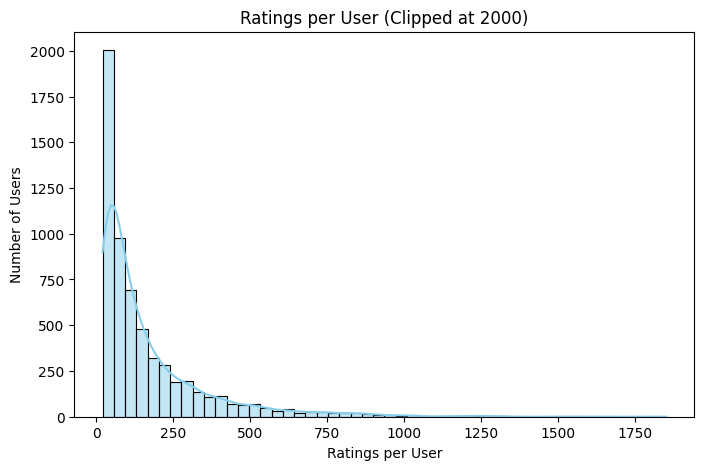

User Ratings per User - Summary:
count    6040.000000
mean      165.597517
std       192.747029
min        20.000000
25%        44.000000
50%        96.000000
75%       208.000000
90%       400.000000
95%       556.000000
99%       906.660000
max      2314.000000
Name: rating, dtype: float64


In [ ]:
ratings_per_user = ratings.groupby("user_id")["rating"].count()

plt.figure(figsize=(8,5))
sns.histplot(ratings_per_user, bins=50, color="orange", edgecolor="black")
plt.title("Number of Ratings per User")
plt.xlabel("Ratings per User ")
plt.ylabel("Number of Users")
plt.show()

# The ratings per user chart is not very useful because a few “power users” rate thousands of movies,
# which skews the distribution. We can make it clearer by Log-scaling the x-axis
plt.figure(figsize=(8,5))
sns.histplot(ratings_per_user, bins=50, color="orange", edgecolor="black")
plt.xscale("log")  # log scale makes skew clearer
plt.title("Number of Ratings per User (Log Scale)")
plt.xlabel("Ratings per User (log scale)")
plt.ylabel("Number of Users")
plt.show()

# We can also Clip outliers and limit it to users who have < 2000 ratings)
plt.figure(figsize=(8,5))
sns.histplot(ratings_per_user[ratings_per_user < 2000], bins=50, color="skyblue", kde=True)
plt.title("Ratings per User (Clipped at 2000)")
plt.xlabel("Ratings per User")
plt.ylabel("Number of Users")
plt.show()

# Print descriptive stats
print("User Ratings per User - Summary:")
print(ratings_per_user.describe(percentiles=[.25,.5,.75,.9,.95,.99]))

### 3. Identify Top users and their preferences

In [ ]:
# Count ratings per user
ratings_per_user = ratings.groupby("user_id")["movie_id"].count().sort_values(ascending=False)

# Top 5 users by rating activity
top_users = ratings_per_user.head(5).index.tolist()
print("Top 5 Users:", top_users)

# For each top user, show their top 5 rated movies
for user in top_users:
    user_ratings = merged[merged["user_id"] == user]
    favorites = user_ratings.sort_values(by="rating", ascending=False).head(5)

    print(f"\nUser {user} - Top Rated Movies:")
    print(favorites[["title", "rating"]])


Top 5 Users: [4169, 1680, 4277, 1941, 1181]

User 4169 - Top Rated Movies:
                                                    title  rating
697936                            Crying Game, The (1992)       5
697949                                    Croupier (1998)       5
695642                             Pawnbroker, The (1965)       5
696829  Star Wars: Episode VI - Return of the Jedi (1983)       5
696833                              Third Man, The (1949)       5

User 1680 - Top Rated Movies:
                                                 title  rating
279498                             Pet Sematary (1989)       5
279499  Midnight in the Garden of Good and Evil (1997)       5
279505                                Christine (1983)       5
279509                             Galaxy Quest (1999)       5
279520                            Unforgettable (1996)       5

User 4277 - Top Rated Movies:
                                    title  rating
712591             Negotiator, The (199

### 4. Average Rating by Genre

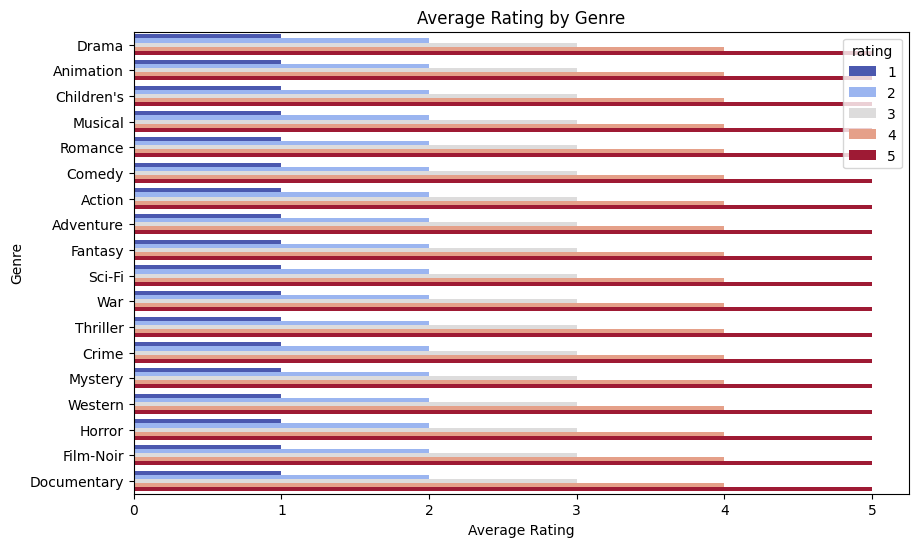

In [ ]:
# Split genres into multiple rows
genres_exploded = merged.assign(genre=merged["genres"].str.split("|")).explode("genre")

plt.figure(figsize=(10,6))
sns.barplot(x="rating", y="genre", data=genres_exploded, errorbar=None, palette="coolwarm", hue="rating")
plt.title("Average Rating by Genre")
plt.xlabel("Average Rating")
plt.ylabel("Genre")
plt.show()


### 5. Most common genres

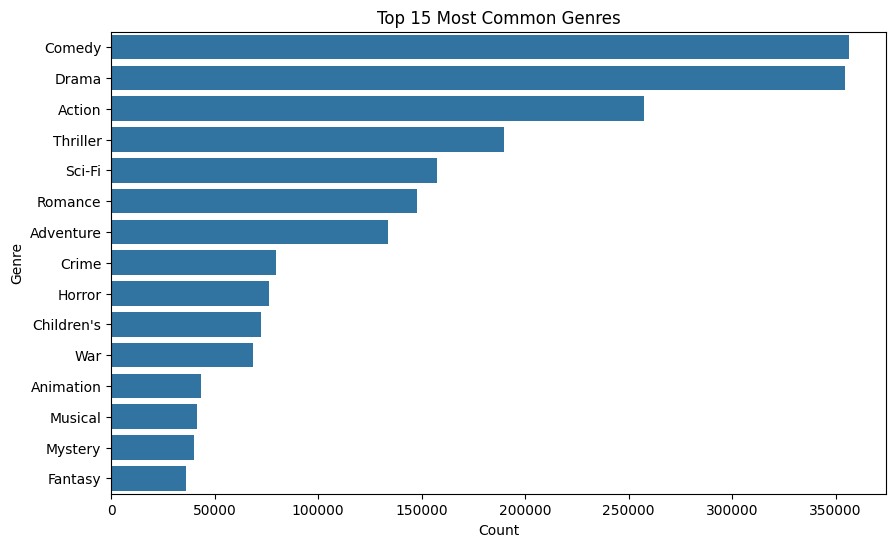

In [ ]:
genre_counts = genres_exploded["genre"].value_counts().head(15)

plt.figure(figsize=(10,6))
sns.barplot(x=genre_counts.values, y=genre_counts.index)
plt.title("Top 15 Most Common Genres")
plt.xlabel("Count")
plt.ylabel("Genre")
plt.show()


### 6. Age group Distribution

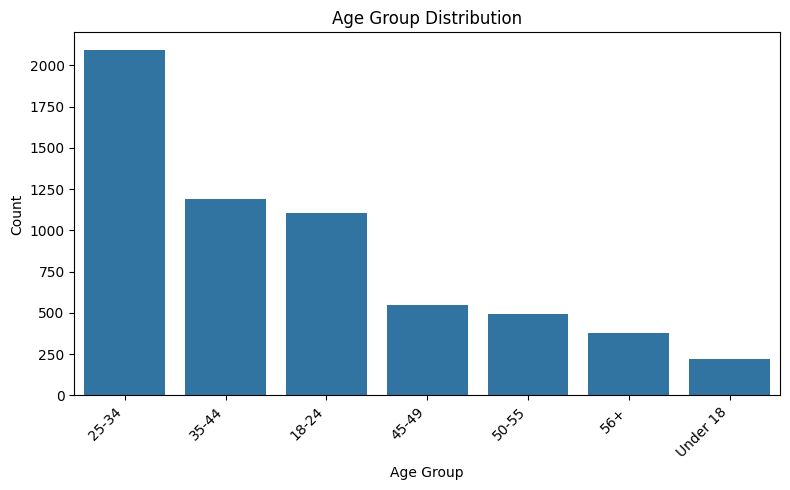

In [ ]:
plt.figure(figsize=(8, 5))
age_order = users["age_desc"].value_counts().index  # order by frequency
sns.countplot(x="age_desc", data=users, order=age_order)
plt.title("Age Group Distribution")
plt.xlabel("Age Group")
plt.ylabel("Count")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()


### 7. Gender distribution across age groups

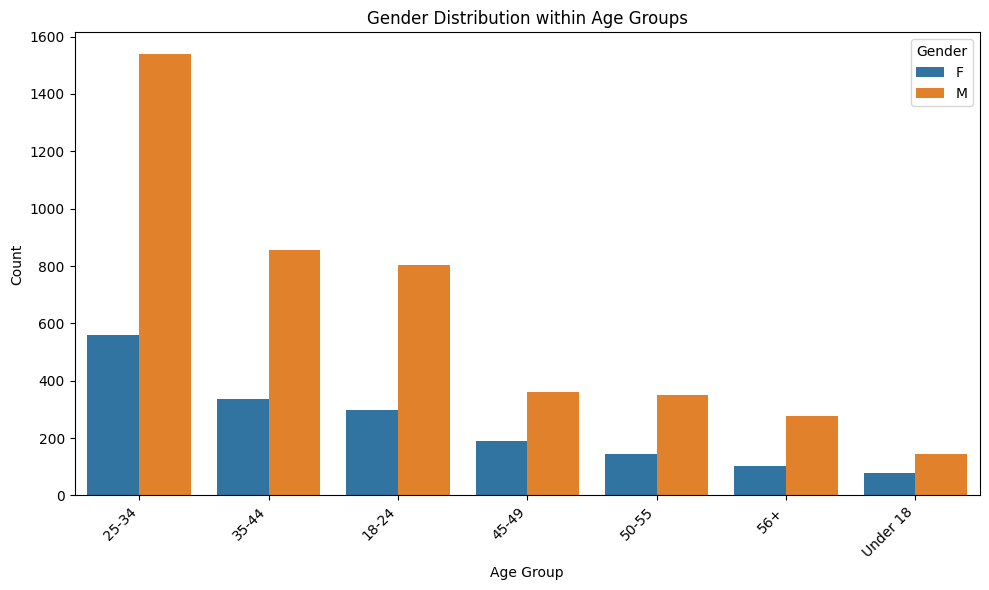

In [ ]:

plt.figure(figsize=(10,6))
sns.countplot(x="age_desc", hue="gender", data=users,
              order=users["age_desc"].value_counts().index)
plt.title("Gender Distribution within Age Groups")
plt.xlabel("Age Group")
plt.ylabel("Count")
plt.xticks(rotation=45, ha="right")
plt.legend(title="Gender")
plt.tight_layout()
plt.show()


## Baseline modal - Linear Regression

In [ ]:
# Feature engineering

# For each user, compute their average rating across all movies.
# For each movie, compute its average rating across all users.
# This captures user bias and movie bias
user_means = merged.groupby("user_id")["rating"].mean()
movie_means = merged.groupby("movie_id")["rating"].mean()

dataset["user_mean"] = dataset["user_id"].map(user_means)
dataset["movie_mean"] = dataset["movie_id"].map(movie_means)

# One-hot encode genres
genre_dummies = dataset["genres"].str.get_dummies(sep="|")
features = pd.concat([dataset[["user_mean", "movie_mean"]], genre_dummies], axis=1)

features.head()

merged.head()

#Train/test split
X_train, X_test, y_train, y_test = train_test_split(features, dataset["rating"], test_size=0.2, random_state=42)

# Train linear regression
linreg = LinearRegression()
linreg.fit(X_train, y_train)

# Predictions
y_pred = linreg.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print("MSE:", mse)
print("RMSE:", rmse)
print("R²:", r2)


MSE: 0.8424845552682851
RMSE: 0.91786957421427
R²: 0.3270255805025569


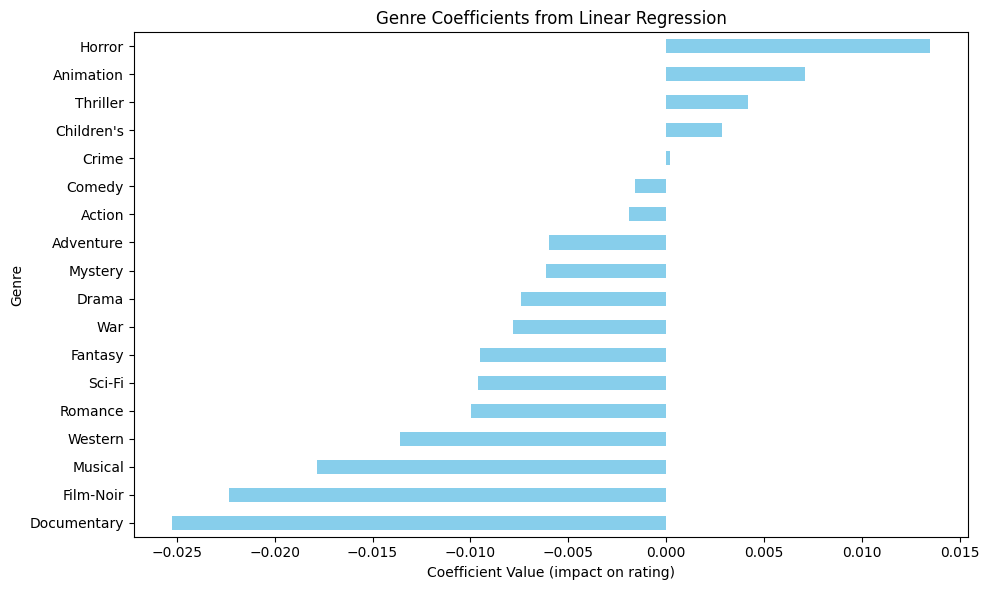

Top positive genres:
 Crime         0.000181
Children's    0.002841
Thriller      0.004185
Animation     0.007116
Horror        0.013507
dtype: float64

Top negative genres:
 Documentary   -0.025262
Film-Noir     -0.022320
Musical       -0.017854
Western       -0.013573
Romance       -0.009987
dtype: float64


In [ ]:
# Get feature names
feature_names = features.columns

# Get coefficients
coefficients = pd.Series(linreg.coef_, index=feature_names)

# Filter only genres
genre_coefs = coefficients.drop(["user_mean", "movie_mean"])

# Sort by importance
genre_coefs = genre_coefs.sort_values()

# Plot
plt.figure(figsize=(10,6))
genre_coefs.plot(kind="barh", color="skyblue")
plt.title("Genre Coefficients from Linear Regression")
plt.xlabel("Coefficient Value (impact on rating)")
plt.ylabel("Genre")
plt.tight_layout()
plt.show()

# Show top/bottom genres numerically
print("Top positive genres:\n", genre_coefs.tail(5))
print("\nTop negative genres:\n", genre_coefs.head(5))


## Like/Dislike Prediction

### Step 1: Define like/dislike labels

* Like = 1 if rating ≥ 4
* Dislike = 0 if rating < 4

In [ ]:
# Create binary target
dataset["like"] = (dataset["rating"] >= 4).astype(int)

# Features (same as before)
X = features
y = dataset["like"]

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

### Step 2. Train multiple classifiers

In [ ]:
# 1. Logistic Regression
log_reg = LogisticRegression(max_iter=200)
log_reg.fit(X_train, y_train)
y_pred_log = log_reg.predict(X_test)

# 2. Decision Tree
dt = DecisionTreeClassifier(
    max_depth=12, min_samples_leaf=10, min_samples_split=50, random_state=42
)
dt.fit(X_train, y_train)
y_pred_dt = dt.predict(X_test)

lin_svc = LinearSVC(dual=True)  # dual=True is fast when n_features > n_samples
lin_svc.fit(X_train, y_train)
y_pred_svm = lin_svc.predict(X_test)

/usr/local/lib/python3.12/dist-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


### 3. Evaluate Models

In [ ]:
print("Logistic Regression")
print(classification_report(y_test, y_pred_log))
print("Accuracy:", accuracy_score(y_test, y_pred_log))

print("\nDecision Tree")
print(classification_report(y_test, y_pred_dt))
print("Accuracy:", accuracy_score(y_test, y_pred_dt))

print("\nSVM")
print(classification_report(y_test, y_pred_svm))
print("Accuracy:", accuracy_score(y_test, y_pred_svm))

Logistic Regression
              precision    recall  f1-score   support

           0       0.70      0.59      0.64     84986
           1       0.73      0.82      0.77    115056

    accuracy                           0.72    200042
   macro avg       0.72      0.70      0.71    200042
weighted avg       0.72      0.72      0.72    200042

Accuracy: 0.7199238159986403

Decision Tree
              precision    recall  f1-score   support

           0       0.70      0.59      0.64     84986
           1       0.73      0.81      0.77    115056

    accuracy                           0.72    200042
   macro avg       0.71      0.70      0.70    200042
weighted avg       0.72      0.72      0.71    200042

Accuracy: 0.7178442527069315

SVM
              precision    recall  f1-score   support

           0       0.71      0.58      0.64     84986
           1       0.73      0.82      0.77    115056

    accuracy                           0.72    200042
   macro avg       0.72      0

## Rank liked movies using the predicted probabilities from the models

In [ ]:
# Build candidate feature matrix for a single user
def _build_candidate_features_for_user(
    user_id: int,
    all_movies: pd.DataFrame,
    interactions: pd.DataFrame,
    user_means: pd.Series,
    movie_means: pd.Series,
    genre_columns: list[str]
):
    # Movies the user has already rated
    seen = set(interactions.loc[interactions["user_id"] == user_id, "movie_id"].unique())

    # Candidate = unseen movies
    cand = all_movies[~all_movies["movie_id"].isin(seen)].copy()
    if cand.empty:
        return cand, pd.DataFrame(columns=["user_mean","movie_mean"] + genre_columns)

    # Add user/movie bias features
    cand["user_id"] = user_id
    cand["user_mean"] = user_means.get(user_id, float(user_means.mean()))
    cand["movie_mean"] = cand["movie_id"].map(movie_means).fillna(float(movie_means.mean()))

    # One-hot the genres to match training columns
    gd = cand["genres"].str.get_dummies(sep="|")
    gd = gd.reindex(columns=genre_columns, fill_value=0)

    X_cand = pd.concat([cand[["user_mean", "movie_mean"]], gd], axis=1)
    return cand, X_cand

# --- 2) Recommend Top-N for a single user ---
def recommend_top_n_for_user(
    user_id: int,
    model,                    # e.g., log_reg or svm (with probability=True) or dt
    all_movies: pd.DataFrame, # movies_df
    interactions: pd.DataFrame, # dataset with user_id, movie_id, rating
    user_means: pd.Series,
    movie_means: pd.Series,
    genre_columns: list[str],
    n: int = 10
) -> pd.DataFrame:
    cand, X_cand = _build_candidate_features_for_user(
        user_id, all_movies, interactions, user_means, movie_means, genre_columns
    )
    if X_cand.empty:
        return pd.DataFrame(columns=["user_id","movie_id","title","genres","score"])

    # Use predicted probability of "like" (class=1)
    if hasattr(model, "predict_proba"):
        scores = model.predict_proba(X_cand)[:, 1]
    else:
        # Fallback: decision_function scaled to 0-1 via min-max
        raw = model.decision_function(X_cand)
        scores = (raw - raw.min()) / (raw.max() - raw.min() + 1e-9)

    cand = cand.copy()
    cand["score"] = scores
    cand["user_id"] = user_id

    cols = ["user_id", "movie_id", "score"]
    if "title" in cand.columns: cols.insert(2, "title")
    cols.append("genres")

    return cand.sort_values("score", ascending=False).head(n)[cols].reset_index(drop=True)


genre_columns = [c for c in features.columns if c not in ("user_mean", "movie_mean")]

# Get Top-10 for a single user
recs_user_5987 = recommend_top_n_for_user(
    5987, log_reg, movies, dataset, user_means, movie_means, genre_columns, n=10
)
print(recs_user_5987)

recs_user_598 = recommend_top_n_for_user(
    598, log_reg, movies, dataset, user_means, movie_means, genre_columns, n=10
)
print(recs_user_598)


   user_id  movie_id                                      title     score  \
0     5987      3280                           Baby, The (1973)  0.927987   
1     5987      3656                               Lured (1947)  0.923630   
2     5987      3233                       Smashing Time (1967)  0.923353   
3     5987      1830                    Follow the Bitch (1998)  0.923353   
4     5987      3382                     Song of Freedom (1936)  0.921334   
5     5987       989  Schlafes Bruder (Brother of Sleep) (1995)  0.921334   
6     5987      3881                   Bittersweet Motel (2000)  0.920839   
7     5987       787         Gate of Heavenly Peace, The (1995)  0.920839   
8     5987      3172                    Ulysses (Ulisse) (1954)  0.920821   
9     5987      3607                   One Little Indian (1973)  0.918282   

                 genres  
0                Horror  
1                 Crime  
2                Comedy  
3                Comedy  
4                 Dram

We are seeing the same Top-N because the features don’t vary by user across candidates (for a given user, user_mean is constant). So the model mostly ranks by movie_mean + genres, which is close to a global popularity list.

Fix: We will need to add a user-specific preference signal. A fast, simple one is a user-genre affinity (how much each user tends to like each genre), then include it as a feature for both training and recommending would make the scores differ per user.

I will explore this in the final submission.

## Content-Based Recommendation Model

This will compute similarity between movies based on movie genres. It will suggest movies that are most similar to a particular movie based on its genre.

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

movies_df = movies.copy()
# Break up the big genre string into a string array
movies_df['genres'] = movies_df['genres'].str.split('|')
# Convert genres to string value
movies_df['genres'] = movies_df['genres'].fillna("").astype('str')

tf = TfidfVectorizer(analyzer='word',ngram_range=(1, 2),min_df=0.0, stop_words='english')
tfidf_matrix = tf.fit_transform(movies_df['genres'])
tfidf_matrix.shape

(3883, 127)

In [ ]:
# Use Cosine Similarity to calculate a numeric quantity that denotes the similarity between two movies.
from sklearn.metrics.pairwise import cosine_similarity
cosine_sim = cosine_similarity(tfidf_matrix, tfidf_matrix)
cosine_sim[:4, :4]

array([[1.        , 0.14193614, 0.09010857, 0.1056164 ],
       [0.14193614, 1.        , 0.        , 0.        ],
       [0.09010857, 0.        , 1.        , 0.1719888 ],
       [0.1056164 , 0.        , 0.1719888 , 1.        ]])

In [ ]:
# Build a 1-dimensional array with movie titles
titles = movies['title']
indices = pd.Series(movies.index, index=movies['title'])

# Function that get movie recommendations based on the cosine similarity score of movie genres
def genre_recommendations(title):
    idx = indices[title]
    sim_scores = list(enumerate(cosine_sim[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:21]
    movie_indices = [i[0] for i in sim_scores]
    return titles.iloc[movie_indices]

In [ ]:
genre_recommendations('Alien Escape (1995)').head(20)

,title
328,Village of the Damned (1995)
508,Robert A. Heinlein's The Puppet Masters (1994)
956,Night of the Living Dead (1968)
1314,"Blob, The (1958)"
1645,Alien Escape (1995)
1793,Species II (1998)
1855,Plan 9 from Outer Space (1958)
2187,Parasite (1982)
2308,Lifeforce (1985)
2359,"Faculty, The (1998)"
